In [1]:
import tensorflow.keras as keras;import tensorflow as tf;import numpy as np;import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape


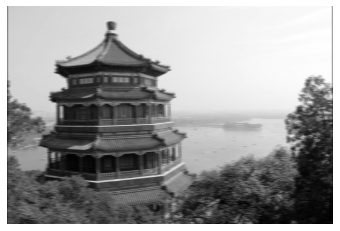

In [ ]:
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.axis("off") # Not shown in the book
plt.show()

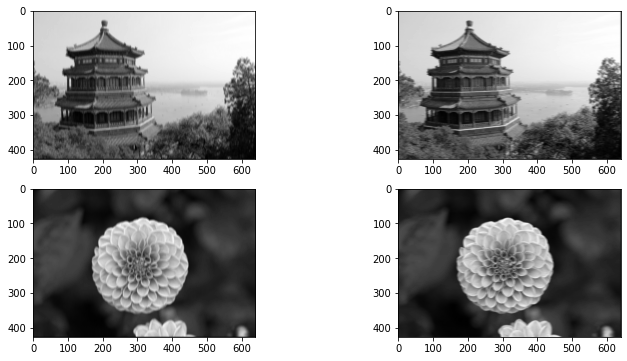

In [ ]:
contador= 0
plt.figure(figsize=(12,6))
for i in range(2):
  for j in range(2):
    contador=contador+1
    plt.subplot(2,2,contador)
    plt.imshow(outputs[i,:,:,j],cmap='gray')
  

## Aplicar filtros a traves de Keras

In [ ]:

conv= keras.layers.Conv2D(filters=3,kernel_size=3,strides=1,padding='SAME',activation='relu',input_shape=outputs.shape)

In [ ]:
conv_omg= conv(images)

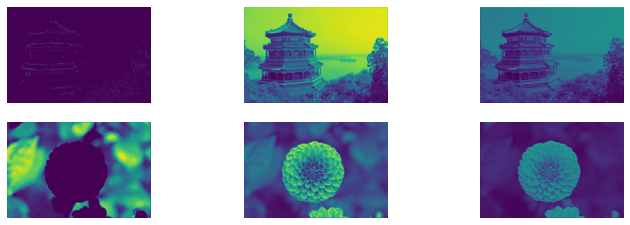

In [ ]:
contador=0
plt.figure(figsize=(12,6))
for i in range(2):
  for j in range(3):
    contador=contador+1
    plt.subplot(3,3,contador)
    plt.imshow(conv_omg[i,:,:,j])
    plt.axis('off')

## Pooling layer

In [ ]:
max_pool= keras.layers.MaxPool2D(pool_size=5,strides=2,padding='SAME')




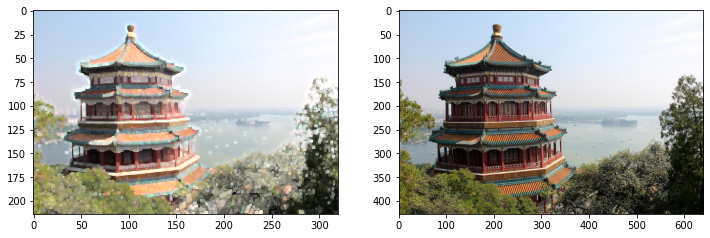

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(max_pool(images)[0])
plt.subplot(1,2,2)
plt.imshow(images[0])


Se observa que la imagen izquierda tiene la mitad de resolución que la ímagen derecha dado que tiene un stride de 2, además se observa como en general la calidad de la ímagen es inferior. Esto es debido al tipo de layer seleccionada, que para este caso fue del tipo MaxPool2D


In [ ]:
class DepthWiseMaxPool(keras.layers.Layer):

  




# CNN Architectures

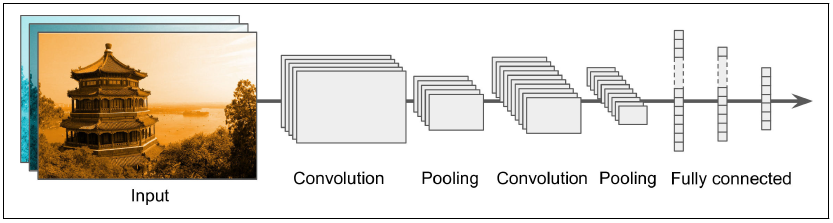

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
from functools import partial
DefaultConv2D = partial(keras.layers.Conv2D,
kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
keras.layers.MaxPooling2D(pool_size=2),
DefaultConv2D(filters=128),
DefaultConv2D(filters=128),
keras.layers.MaxPooling2D(pool_size=2),
DefaultConv2D(filters=256),
DefaultConv2D(filters=256),
keras.layers.MaxPooling2D(pool_size=2),
keras.layers.Flatten(),
keras.layers.Dense(units=128, activation='relu'),
keras.layers.Dropout(0.5),
keras.layers.Dense(units=64, activation='relu'),
keras.layers.Dropout(0.5),
keras.layers.Dense(units=10, activation='softmax'),
])

In [ ]:

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 [==============================] - 629s 365ms/step - loss: 0.6949 - accuracy: 0.7601 - val_loss: 0.3787 - val_accuracy: 0.8656
Epoch 2/10
1719/1719 [==============================] - 620s 361ms/step - loss: 0.4206 - accuracy: 0.8581 - val_loss: 0.3255 - val_accuracy: 0.8778
Epoch 3/10
1719/1719 [==============================] - 612s 356ms/step - loss: 0.3576 - accuracy: 0.8799 - val_loss: 0.3085 - val_accuracy: 0.8840
Epoch 4/10
1719/1719 [==============================] - 614s 357ms/step - loss: 0.3238 - accuracy: 0.8899 - val_loss: 0.2944 - val_accuracy: 0.8950
Epoch 5/10
1719/1719 [==============================] - 615s 358ms/step - loss: 0.3088 - accuracy: 0.8944 - val_loss: 0.2753 - val_accuracy: 0.9036
Epoch 6/10
1719/1719 [==============================] - 616s 359ms/step - loss: 0.2880 - accuracy: 0.9000 - val_loss: 0.3085 - val_accuracy: 0.8898
Epoch 7/10
1719/1719 [==============================] - 617s 359ms/step - loss: 0.2739 - accuracy: 0.9073 - val_

In [ ]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 22s 71ms/step - loss: 0.2909 - accuracy: 0.9034


[0.29085883498191833, 0.9034000039100647]

# RetNet-34 CNN

In [ ]:
import tensorflow.keras as keras
import tensorflow as tf
import numpy as np
from functools import partial

DefaultCon2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1, padding='SAME', use_bias=False)


class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, stride=1, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [DefaultCon2D(filters, strides=stride), keras.layers.BatchNormalization(), self.activation,
                            DefaultCon2D(filters),
                            keras.layers.BatchNormalization()]

        self.skip_layers = []
        if stride > 1:
            self.skip_layers = [
                DefaultCon2D(filters, kernel_size=1, strides=stride),
                keras.layers.BatchNormalization()]

    def call(self, inputs, *args, **kwargs):
        z = inputs
        for layer in self.main_layers:
            z = layer(z)
        skip = inputs
        for ski_layer in self.skip_layers:
            skip = ski_layer(skip)

        return self.activation(z + skip)


In [ ]:
modelo = keras.models.Sequential()
modelo.add(DefaultCon2D(64, kernel_size=7, strides=2,input_shape=[28, 28, 1]))
modelo.add(keras.layers.BatchNormalization())
modelo.add(keras.layers.Activation('relu'))
modelo.add(keras.layers.MaxPool2D(pool_size=2,strides=2,padding='SAME'))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    modelo.add(ResidualUnit(filters, stride=strides))
    prev_filters = filters
modelo.add(keras.layers.GlobalAvgPool2D())
modelo.add(keras.layers.Flatten())
modelo.add(keras.layers.Dense(10, activation="softmax"))

# Pretrained Models

In [ ]:
modelo.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = modelo.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
   8/1719 [..............................] - ETA: 56:49 - loss: 3.1540 - accuracy: 0.3555

KeyboardInterrupt: ignored

### Pretrained models




In [16]:
modelo= keras.applications.ResNet152()

china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
inputs= keras.applications.resnet50.preprocess_input(images_resized*255)
Y_proba=modelo.predict(inputs)


242900992/242900224 [==============================] - 2s 0us/step


In [17]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)

In [18]:
top_K

[[('n02825657', 'bell_cote', 0.92760617),
  ('n03877845', 'palace', 0.061217744),
  ('n03781244', 'monastery', 0.010140148)],
 [('n03530642', 'honeycomb', 0.21471296),
  ('n04522168', 'vase', 0.15350683),
  ('n07734744', 'mushroom', 0.15037718)]]

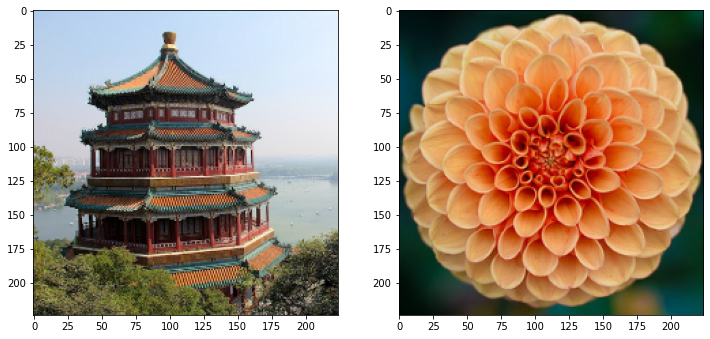

In [12]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(images_resized[0])
plt.subplot(1,2,2)
plt.imshow(images_resized[1])